### **Linear regression with sklearn API**

The objective of this notebook is to demonstrate how to build a linear regression model with `sklearn`. 

We will be using the following set up:

1. Dataset : California Housing

2. Regression API : `LinearRegression`

3. Training : `fit` (normal equation) and `cross_validate` (normal equation with cross  validation).

4. Evaluation : `score` (r2 Score) and `cross_val_score` with different scoring parameters.

We will study the model diagnosis with `LearningCurve` and learn how to examine the learned model or weight vector.



### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

In [2]:
np.random.seed(42)
plt.style.use('seaborn')

We will use `ShuffleSplit` cross validation with:

* 10 folds (n_splits) and 

* set aside 20% examples as test examples (`test_size`) 


In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

### STEP 1:  **Load the dataset**

The first step is to load the dataset. We have already discussed how to load California Housing dataset in the last demonstration.

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

The feature matrix is loaded in `features` dataframes and the labels in `labels` dataframe. 

Let's examine the shapes of these two dataframes.

In [5]:
print('Shape of feature matrix : ', features.shape)
print('Shape of labels matrix : ', labels.shape)

Shape of feature matrix :  (20640, 8)
Shape of labels matrix :  (20640,)


As a sanity check, make sure that the number of rows in feature matrix and labels match.

In [6]:
assert (features.shape[0]==labels.shape[0])

### STEP 2: **Data Exploration**

Data exploration has beein covered in week 4 notebook.

### STEP 3: **Preprocessing and model building** 


#### 3A. Train-test split

The first step is to split the training data into test set. We do not access the test data till the end. 

All data exploration and tuning is performed on the training set and by setting aside a small portion of training as a dev or validation set.

The following code snippet divides the data into training and test sets : 

In [7]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 8158 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      15480 non-null  float64
 1   HouseAge    15480 non-null  float64
 2   AveRooms    15480 non-null  float64
 3   AveBedrms   15480 non-null  float64
 4   Population  15480 non-null  float64
 5   AveOccup    15480 non-null  float64
 6   Latitude    15480 non-null  float64
 7   Longitude   15480 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


Let's examine the shapes of training and tet sets : 

In [8]:
print('Number of training samples : ', train_features.shape[0])
print('Number of test samples : ', test_features.shape[0])

Number of training samples :  15480
Number of test samples :  5160


It's time to perform another sanity check-here we check if the training feature matrix has the same umber of rows as the training label vector.

We perform the same check on the test set too.

In [9]:
assert (train_features.shape[0] == train_labels.shape[0])
assert (test_features.shape[0] == test_labels.shape[0])

#### 3B. Pipeline : Preprocessing + Model Building

* As a first step, build linear regression models with default parameter setting of `LinearRegression` APIs.

* We will make use of `Pipeline` API for combining data preprocessing and model building.

* We will use `StandardScaler` feature scaling to bring all features on the same scale followed by a `LinearRegression` model.

The `Pipeline` object has two components:
1. `StandardScaler` as step1 
2. `LinearRegression` as step2 

After constructing the pipeline object, let's train it with set : 

In [10]:
lin_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model, let's check the learnt / estimated weight vectors (intercept_, coef_) : 

In [11]:
print('Intercept (w_0) : ',lin_reg_pipeline[-1].intercept_)
print()
print('Weight vector (w_1,w_2....,w_m) : \n' ,lin_reg_pipeline[-1].coef_)

Intercept (w_0) :  2.0703489205426377

Weight vector (w_1,w_2....,w_m) : 
 [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


A few things to notice:

* We accessed the `LinearRegression` object as `lin_reg_pipeline[-1]` which is the last step in pipeline. 

* The intercept can be obtained via `intercept_` memeber variable and 

* The weight vector correspoinding to features via `coef_`. 


### STEP 4: **Model Evaluation**

Let's use `score` method to obtain train and test errors with twin objectives.

* Estimation of model performance as provided by test error.

* Comparision of errors for model diagnostic purpose (underfit /overfit /just the right fit)


In [12]:
#evaluate model performance on both train and test set.

train_score = lin_reg_pipeline.score(train_features, train_labels)
print('Model performance on train set :', train_score)

test_score = lin_reg_pipeline.score(test_features, test_labels)
print('Model performance on test set :', test_score)

Model performance on train set : 0.609873031052925
Model performance on test set : 0.5910509795491352


* The `score` method returns `r2` score whose best value is 1. 

* The `r2` scores on training and test are comparable but they are not that high. 

* It points to underfitting issue in model training.


#### 4A. Cross validation sccore (`cross_val_score`) 

* Since the `score` was computed on one fold that was selected as a test set, it may not be all that robust. 

* In order to obtain robust estimate of the performance, we use `cross_val_score` that calculates `score` on different test folds through cross validation.


In [13]:
lin_reg_score = cross_val_score(lin_reg_pipeline, train_features, train_labels,scoring='neg_mean_squared_error' , cv=shuffle_split_cv)

print('Model performance on cross validation set : \n', lin_reg_score)

Model performance on cross validation set : 
 [-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]


In [14]:
print(
    f'Score of linear regression model on the test set : \n'f"{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}")

Score of linear regression model on the test set : 
-0.529 +/- 0.022


Here we got the negative mean squred error as a score. We can convert that to error as follows:

In [15]:
lin_reg_mse = - lin_reg_score

print(
    f'MSE of linear regression model on the test set :\n' f'{lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}')

MSE of linear regression model on the test set :
0.529 +/- 0.022


We can use other `scoring` parameters and obtain cross validated scores based on that parameter. 

The following choices are available for `scoring`: 

* expalined_variance

* max_error

* neg_mean_absolute_error

* neg_root_mean_squared_log_error

* neg_median_absolute_error

* neg_mean_absolute_percentage_error 

* r2 score


#### 4B. Cross validation 

We just calculated `cross_val_score` based on the cross validation. 

* It however return only scores of each fold. What if we also need to access the models trained in each fold along with some other statistics like `train error` for that fold.

* `cross_validate` API enables us to obtain them.

In [16]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline ,train_features ,train_labels ,scoring='neg_mean_squared_error' ,return_train_score=True ,return_estimator=True ,cv=shuffle_split_cv)

The `lin_reg_cv_results` is a dictionary with the following contents : 

* trained `estimators`

* time taken for fitting (`fit_time`) and scoring(`score_time`) the models in cross validation,

* training score (`train_score`) and 

* test scores (`test_score`) 


##### **Returns of cross_validate score**

* scoresdict of float arrays of shape (n_splits,)

* Array of scores of the estimator for each run of the cross validation.

* A dict of arrays containing the score/time arrays for each scorer is returned. 

* The possible keys for this dict are:

1. **test_score**

    * The score array for test scores on each cv split. 
    
    * `Suffix_score` in `test_score` changes to a specific metric like `test_r2` or `test_auc` if there are multiple scoring metrics in the scoring parameter.

2. **train_score**

    * The score array for train scores on each cv split. 
    
    * `Suffix_score` in `train_score` changes to a specific metric like `train_r2` or `train_auc` if there are multiple scoring metrics in the scoring parameter. 
    
    * This is available only if `return_train_score` parameter is `True`.

3. **fit_time**
    
    * The time for fitting the estimator on each cv split. 
    
    * This is available only if `return_fit_time` parameter is `True`.

    * The time for fitting the estimator on the train set for each cv split.


4. **score_time**

    The time for scoring the estimator on the test set for each cv split. (Note time for scoring on the train set is not included even if return_train_score is set to True)

5. **estimator**

    * The estimator objects for each cv split. 
    
    * This is available only if `return_estimator` parameter is set to `True`.


Let's print the contents of the dictionary for us to examine : 

In [17]:
lin_reg_cv_results

{'fit_time': array([0.00901079, 0.00700426, 0.0069983 , 0.00900698, 0.00699949,
        0.0059979 , 0.00700974, 0.00700021, 0.00800037, 0.00799966]),
 'score_time': array([0.00099754, 0.00100017, 0.00099826, 0.0009954 , 0.00100088,
        0.00099993, 0.00101876, 0.00199103, 0.00099969, 0.0009973 ]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

* There are 10 values in each dictionary key. That is because of `cv`=10 or 10-fold cross validation that we used.

* We compare training and test errors to access generalization performance of our model. However we have training and test scores in the `cv_results` dictionary.

* Multiply these scores by -1 and convert them to errors.

In [18]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f'Mean squared error of linear regression model on the train set:\n',
      f'{train_error.mean():.3f} +\- {train_error.std():.3f}')

print()
print(f'Mean squared error of linear regression model on the test set:\n',
      f'{test_error.mean():.3f} +\- {test_error.std():.3f}')

Mean squared error of linear regression model on the train set:
 0.519 +\- 0.006

Mean squared error of linear regression model on the test set:
 0.529 +\- 0.022


#### 4C. **Learning Curve** / Effect of training set size on ERROR

Let's understand how the training set size or #samples affect the error. 

We can use `Learning_curve` API that calculates cross validation scores for different #samples as specified in argument `train_sizes`. 

In [19]:
#@ title [Plot learning curves]
def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_score_mean = np.mean(-train_scores, axis=1)
    train_score_std = np.std(-train_scores, axis=1)

    test_score_mean = np.mean(-test_scores, axis=1)
    test_score_std = np.std(-test_scores, axis=1)
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.fill_between(train_sizes,
                    train_score_mean - train_score_std,
                    train_score_mean + train_score_std,
                    alpha=0.1,
                    color='r',)

    plt.fill_between(train_sizes,
                    test_score_mean + test_score_std,
                    test_score_mean - test_score_std,
                    alpha=0.1,
                    color='g')

    plt.plot(train_sizes, train_score_mean, "o-", color='r', lw=2)
    plt.plot(train_sizes, test_score_mean, "o-", color='g', lw=2)

    plt.xlabel("Training examples ")
    plt.ylabel("MSE")
    # plt.legend(loc="best")

    return plt.show()

In [20]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = learning_curve(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,scoring='neg_mean_squared_error', n_jobs=-1,
return_times=True, train_sizes=np.linspace(0.2, 1, 10))

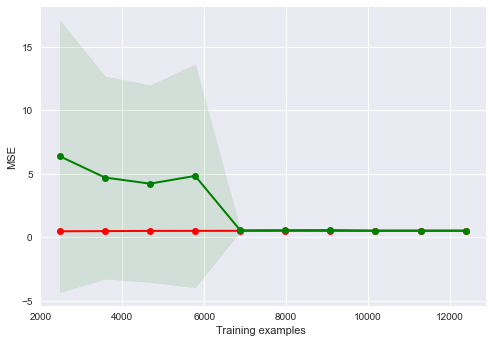

In [21]:
plot_learning_curve(train_sizes, train_scores, test_scores)

Observing that : 

* Both curves have reached a plateau; they are close and fairly high.

* Few instances in the training set means the model can fit them perfectly. But as more instances are added to the training set, it becomes impossible for the model to fit the training data perfectly.

* When the model is trained on very few training instances, it is not able of generalizing properly, which is why the validation error is initially quite high. 

* Then as the model learns on more training examples, the training and validation error reduce slowly.

These learning curves are typical of **underfitting** model.

#### 4D. **Scalability Curve** / Effect of training set size on FIT TIME

We can also study how training scales as the function of number of training samples.

In [22]:
#@ title [Plot Scalability curves]
def plot_scalability_curve(train_sizes, fit_times):
    train_score_mean = np.mean(-train_scores, axis=1)
    train_score_std = np.std(-train_scores, axis=1)

    test_score_mean = np.mean(-test_scores, axis=1)
    test_score_std = np.std(-test_scores, axis=1)

    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.fill_between(train_sizes,
                    fit_times_mean - fit_times_std,
                    fit_times_mean + fit_times_std,
                    alpha=0.1,
                    color='g',)

    plt.plot(train_sizes, fit_times_mean, "o-", color='b', lw=2)

    plt.xlabel("Training examples ")
    plt.ylabel("fit time")
    # plt.legend(loc="best")
    
    return plt.show()


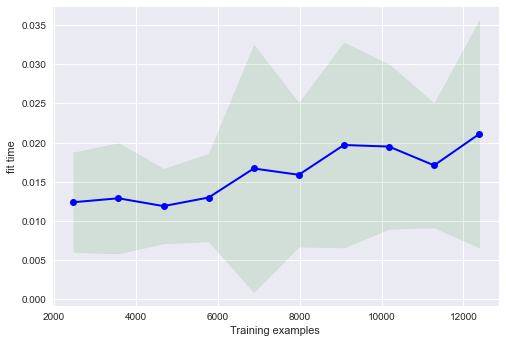

In [23]:
plot_scalability_curve(train_sizes,fit_times)

As the number of training examples grows, the time to fit also increases.

#### 4E. Model Examination

Let's examine the weight vectors and how much variability exists between them across different cross-validated models.

In [24]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

For this we will first construct a dataframe of weight vectors and then plot them with `boxplot`.

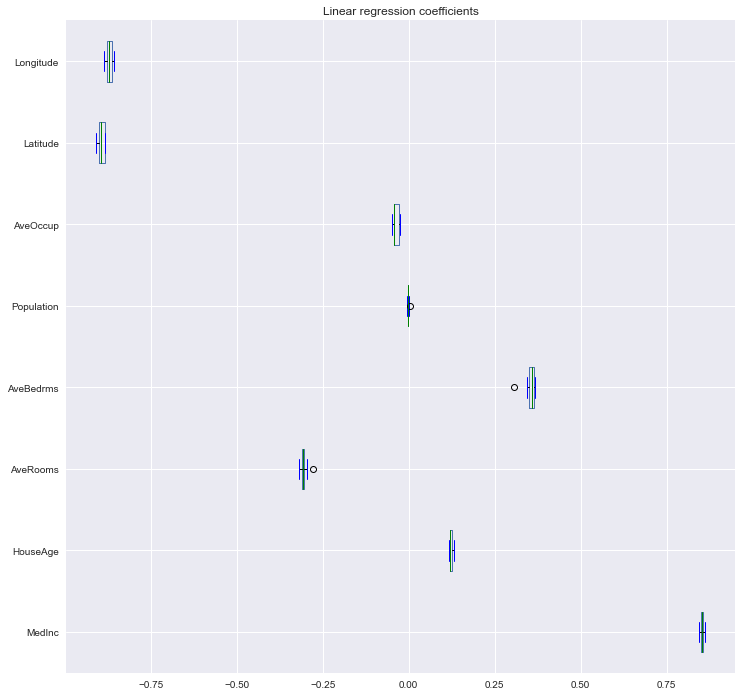

In [25]:
coefs = [i[-1].coef_ for i in lin_reg_cv_results["estimator"]] 
weights_df = pd.DataFrame(coefs, columns=feature_names)

color = {'whiskers':'black','medians':'green','caps':'blue'}
weights_df.plot.box(color=color, vert=False,figsize=(12,12))

plt.title('Linear regression coefficients')
plt.show()

There is not much variability in weights by different models. It can also be seen in the standard deviation of weights as seen in `std` row below

In [26]:
weights_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,10.0,0.852153,0.005763,0.843517,0.848871,0.852711,0.854743,0.861659
HouseAge,10.0,0.122770,0.004312,0.117394,0.119895,0.121592,0.125520,0.130560
AveRooms,10.0,-0.304384,0.010998,-0.318971,-0.310778,-0.305795,-0.302980,-0.278426
AveBedrms,10.0,0.353528,0.018044,0.307474,0.349715,0.360139,0.364646,0.367952
Population,10.0,-0.001576,0.003254,-0.005787,-0.002688,-0.002063,-0.000350,0.005297
AveOccup,10.0,-0.037059,0.008582,-0.047584,-0.042486,-0.042325,-0.027562,-0.026331
Latitude,10.0,-0.894011,0.009975,-0.908058,-0.901411,-0.895370,-0.883967,-0.881884
Longitude,10.0,-0.869753,0.009097,-0.884206,-0.876542,-0.869631,-0.862110,-0.857844


#### 4F. Model Selection

Let's select the model with the lowest cross validated test error as the best performance model.

In [27]:
lin_reg_cv_results['estimator']

[Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_scaling', StandardScaler()),
                 ('lin_reg', LinearRegression())]),
 Pipeline(steps=[('feature_s

In [28]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

Let's examine the model coefficients and intercepts :

In [29]:
print('Intercept (w_0) :',selected_model['lin_reg'].intercept_)
print()
print('Coefficients (w_1,w_2.....,w_m) : \n',selected_model['lin_reg'].coef_)

Intercept (w_0) : 2.0779898917958657

Coefficients (w_1,w_2.....,w_m) : 
 [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


#### 4G. Model Performance

Towards this, let's first obtain the predictions for test points in cross validation.

In [30]:
from sklearn.model_selection import cross_val_predict

cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)

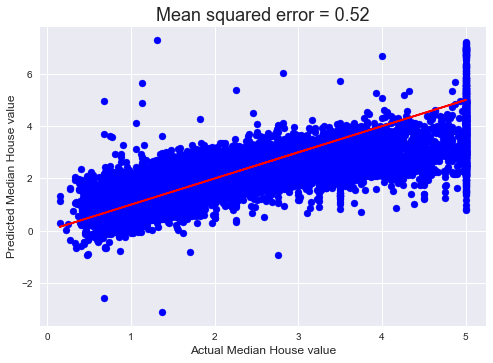

In [31]:
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')

plt.title(f'Mean squared error = {mse_cv:.2f}', size=18)
plt.xlabel('Actual Median House value', size=12)
plt.ylabel('Predicted Median House value', size=12)
plt.show()

* The model seems to be all over the place in its predictions for examples with label 5. 

* There are some negative predictions. We can fix this by adding a constraints on the weights to be positive.


At this stage, we should perform error analysis and check where the predictions are going wrong. 

We can revisit feature construction, preprocessing or model stages and make the necessary course corrections to get better performance.

### STEP 5 : **Predictions**

We can use the best performing model from cross validation for getting predictions on the test set.

In [32]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

In [33]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

### STEP 6 : **Report Model Performance**

We report the model perfromance on the test set.

In [34]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print('R2 score for the best model obtained via cross validation :', score_cv)
print('R2 score for model w/o cv :', score)

R2 score for the best model obtained via cross validation : 0.5923577635319087
R2 score for model w/o cv : 0.5910509795491352


Alternatively we can use any other metric of interest and report performance based on that. 

For example, the mean squared error is as follows:

In [35]:
mse_cv = mean_squared_error(test_labels, test_predictions_cv)
mse = mean_squared_error(test_labels, test_predictions)

print('MSE for the best model obtained via cross validation :', mse_cv)
print('MSE for model w/o cv : ', mse)

MSE for the best model obtained via cross validation : 0.5393995876218524
MSE for model w/o cv :  0.5411287478470688


#### Testing Model on other metrics 

In [36]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2, random_state=0)

lin_reg_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_pipeline.fit(X_train, y_train)
test_score = lin_reg_pipeline.score(X_test, y_test)
test_score


0.660514059153199

In [37]:
y_pred = lin_reg_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.703338350752188

In [38]:
explained_variance_score(y_test, y_pred)

0.6605500501742702

In [39]:
max_error(y_test,y_pred)

7.260453292958401

In [40]:
mean_absolute_error(y_test, y_pred)

0.5168526993787042

In [41]:
mean_squared_error(y_test, y_pred)

0.4946848356388078

### **BASELINE MODELS**

Now, we will build a couple of baseline models using `DummyRegression` and `permutation_test_score`. 

We will compare performance of our linear regression model with these two baselines.

We will use `ShuffleSplit` as a cross validation strategy 

In [42]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test.

In [43]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels,  random_state=42)

#### 1. Linear Regression Classifier


* Build linear regression model with feature scaling as part of a pipeline.

* Train the model with 10-fold cross validation via ShuffleSplit.

* Capture errors on different folds.

In [44]:
lin_reg_pipeline = Pipeline([
    ('feature scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features,       train_labels, cv=shuffle_split_cv, scoring='neg_mean_absolute_error', n_jobs=-1)

lin_reg_error = pd.Series(-lin_reg_cv_results['test_score'],
                           name='Linear regressor error')

lin_reg_cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

#### 2. Dummy Regression Classifier

In [45]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    baseline_model_median = DummyRegressor(strategy=strategy,
                                            constant=constant_val,
                                            quantile=quantile_val)

    baseline_median_cv_results = cross_validate(
        baseline_model_median, train_features, train_labels, cv=shuffle_split_cv, n_jobs=-1,  scoring='neg_mean_absolute_error')

    return pd.Series(-baseline_median_cv_results['test_score'], name="Dummy regressor error")


In [46]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')

baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')

baseline_constant_cv_results_errors = dummy_regressor_baseline(
    strategy='constant', constant_val=2)

baseline_quantile_cv_results_errors = dummy_regressor_baseline(
    strategy='quantile', quantile_val=0.55)

Let's compare performance of these Dummy Regressors:

In [47]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors,
                            baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors,
                            baseline_quantile_cv_results_errors], axis=1)

dummy_error_df.columns = ['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']
dummy_error_df

,Median CV,Mean CV,Constant CV,Quantile CV
0,0.881187,0.918341,0.902993,0.891847
1,0.873773,0.898484,0.886983,0.877153
2,0.876366,0.894307,0.885488,0.877260
3,0.892083,0.915112,0.904889,0.895924
4,0.876835,0.909209,0.895593,0.884722
5,0.874685,0.903733,0.890999,0.880856
6,0.864097,0.902037,0.886215,0.874646
7,0.888523,0.917216,0.904945,0.894905
8,0.890963,0.921880,0.908874,0.898323
9,0.886765,0.919369,0.905994,0.895436


Plotting erros using `barplot`

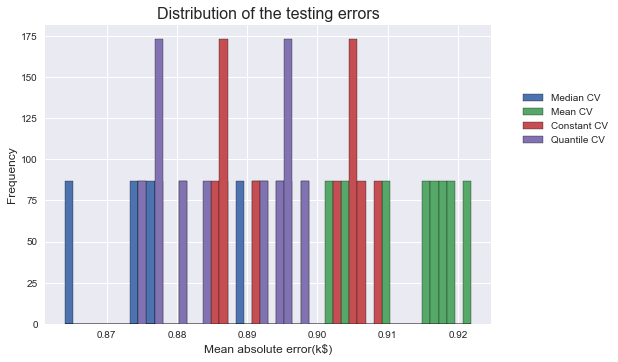

In [48]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')

plt.legend(bbox_to_anchor=(1.05,0.8), loc='upper left')
plt.xlabel('Mean absolute error(k$)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of the testing errors' ,size=16)
plt.show()

#### Permutation_test_score 

It permutes the target to generate randomized data and computes the empirical p-value against the null hypothesis, that features and targets are independent.

Here we are interested in `permutation_score` returned by this API, which indicates score of the model on different permutations.

In [49]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, scoring='neg_mean_absolute_error', n_jobs=-1, n_permutations=30)

permutation_errors = pd.Series(-permutation_score, name='Permuted error')

In [50]:
print('Permutation test score :\n', permutation_score)

Permutation test score :
 [-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


#### Model Comparision 

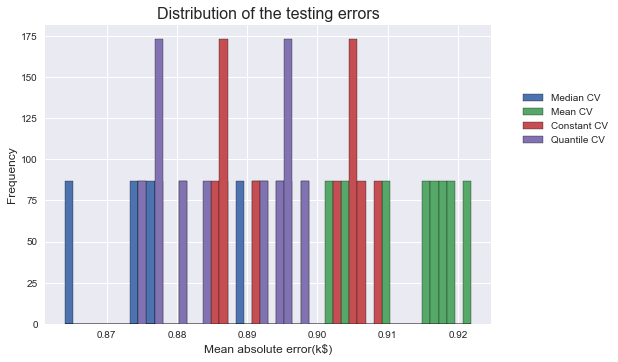

In [51]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')

plt.legend(bbox_to_anchor=(1.05,0.8), loc='upper left')
plt.xlabel('Mean absolute error(k$)', size=12) 
plt.ylabel('Frequency', size=12)
plt.title('Distribution of the testing errors' ,size=16)
plt.show()

In [52]:
errors_df = pd.concat([lin_reg_error, baseline_median_cv_results_errors,permutation_errors], axis=1)

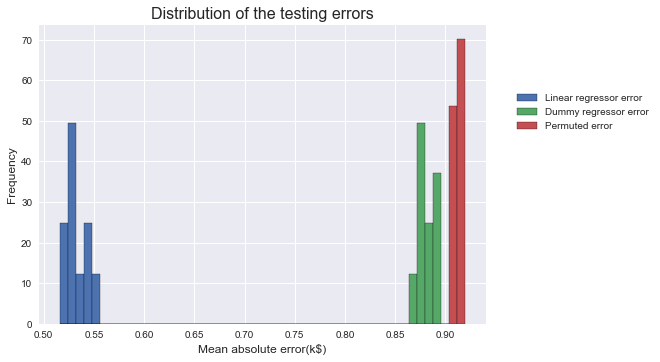

In [53]:
errors_df.plot.hist(bins=50, density=True, edgecolor='black')

plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.xlabel('Mean absolute error(k$)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of the testing errors', size=16)
plt.show()
